Importing Libraries

In [2]:
import requests
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()

APIKEY = os.getenv('API_KEY')

Coin Gecko API Requests

In [10]:
#Testing the Coin Gecko API: Making a request to fetch the prices of different coins from the past 90 days in USD


def fetch_data(crypto_id, apikey, currency='usd', days='90'):
    url = f"https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart?vs_currency={currency}&days={days}"

    headers = {
        "accept": "application/json",
        "x_cg_demo_api_key": apikey
    }

    response = requests.get(url, headers=headers)
    data = response.json()
    # print("This is what the data from the request looks like in json format: ")
    # print(data['target_allocation'])
    prices = [price[1] for price in data['prices']]

    return prices

In [11]:
#Using the function to fetch the prices for bitcoin from the past 90 days

prices = fetch_data("bitcoin")
print(prices[-1])

94570.23129453354


Visualize The Data

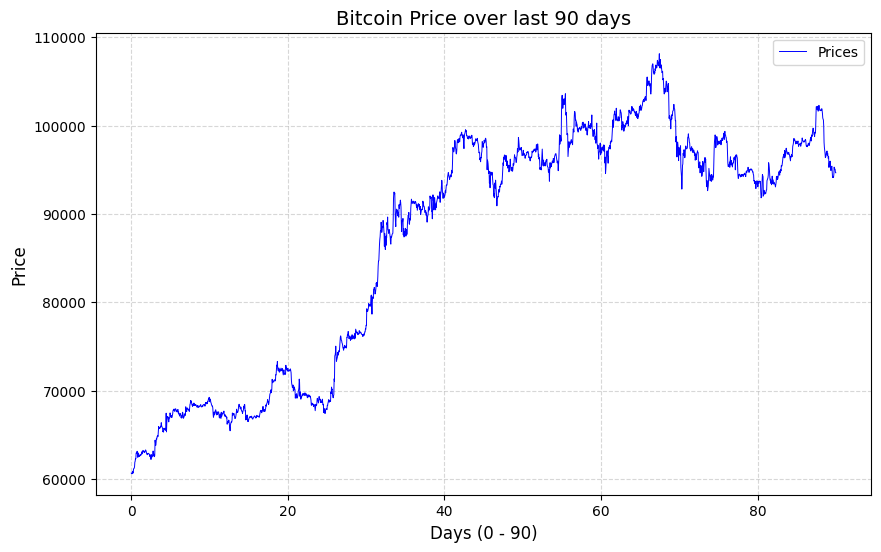

In [5]:
# Generate x values from 0 to 90, evenly spaced for 2160 points
x_values = np.linspace(0, 90, 2161)

# Plot the prices
plt.figure(figsize=(10, 6))
plt.plot(x_values, prices, label="Prices", color="blue", linewidth=0.7)

# Add labels, title, and grid
plt.title("Bitcoin Price over last 90 days", fontsize=14)
plt.xlabel("Days (0 - 90)", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Show the plot
plt.show()


Preprocessing the Data

In [6]:
from sklearn.model_selection import train_test_split

def DataPreprocessing_and_SplitData(prices):
    # Use MinMax Scaler to feature scale the prices
                # This is a type of transformation used to shift and rescale values so that each value is on a scale between 0-1
                        # Useful for when you have different features with different scales and you want to make sure all have a similar range of numbers
    scaler = MinMaxScaler(feature_range=(0, 1))

    # .reshape(-1, 1), you transform a 1D array of shape (length of prices,) into a 2D array of shape (length of prices, 1), turning it into a column vector
                # This is often useful when you're working with machine learning models or other algorithms that expect input in the form of 2D arrays or matrices.
    prices = np.array(prices).reshape(-1, 1)

    # Apply the Scaler to the data
    prices_normalized = scaler.fit_transform(prices)


    # To train the LSTM Model we use sequences of prices so that it can predict a target for that sequence
                # We are going to use every 30 prices to predict the 31st price in the sequence of prices
                # Create sequences of 30 prices (input) and the next price (target)
    sequence_length = 30
    X, y = [], []
    for i in range(len(prices_normalized) - sequence_length):

        #Uses list indexting to select the prices from [0, 29] with [30] as the target up until [prices_length - 30, prices_length] with [price_length] as the target
        X.append(prices_normalized[i:i + sequence_length])   
        y.append(prices_normalized[i + sequence_length])

    # Convert to Numpy Array

    X, y = np.array(X), np.array(y)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, scaler


In [7]:
bit_seq_train, bit_seq_test, bit_targ_train, bit_targ_test, scalar = DataPreprocessing_and_SplitData(prices)

In [8]:
print(len(bit_seq_train))
print(len(bit_targ_train))
print(len(bit_seq_test))
print(len(bit_targ_test))


1704
1704
427
427


Build LSTM Model

In [9]:
#Long Short-Term Memory Models
    # Type of recurrent neural network (RNN) designed to capture long-term dependencies in sequential data
    # Unlike traditional RNNs, LSTMs are equipped with a special architecture that includes memory cells and gates (input gate, forget gate, and output gate) to control the flow of information
    # This helps them remember information over longer periods and avoid the vanishing gradient problem.

def LSTM_Model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(50, return_sequences=True),
        LSTM(50),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

In [10]:
LSTM = LSTM_Model((bit_seq_train.shape[1], bit_seq_train.shape[2]))

Train The LSTM Model

In [11]:
# Training the LSTM model and Using Early stopping if the loss goes up or stays consistent for a number of epochs
    # Early Stopping helps prevent overfitting during training but we can only use with validation data which we do not have


# early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
LSTM_history = LSTM.fit(bit_seq_train, bit_targ_train, epochs=50, batch_size=32)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0832
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.3787e-04
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.2133e-04
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.6452e-04
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.6923e-04
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.2158e-04
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.0422e-04
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.2081e-04
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.4515e-04
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.2208e-04
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.7203e-04
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.1863e-04
Epoch 13/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.5813e-04
Epoch 14/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.4083e-04
Epoch 15/50
54/54 ━

Test and Evaluate the LSTM Model

In [12]:

# Predict and inverse-transform to original scale
LSTM_y_pred = LSTM.predict(bit_seq_test)
LSTM_y_pred_original = scalar.inverse_transform(LSTM_y_pred)
LSTM_y_test_original = scalar.inverse_transform(bit_targ_test.reshape(-1, 1))


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


Visualize LSTM Data Predictions

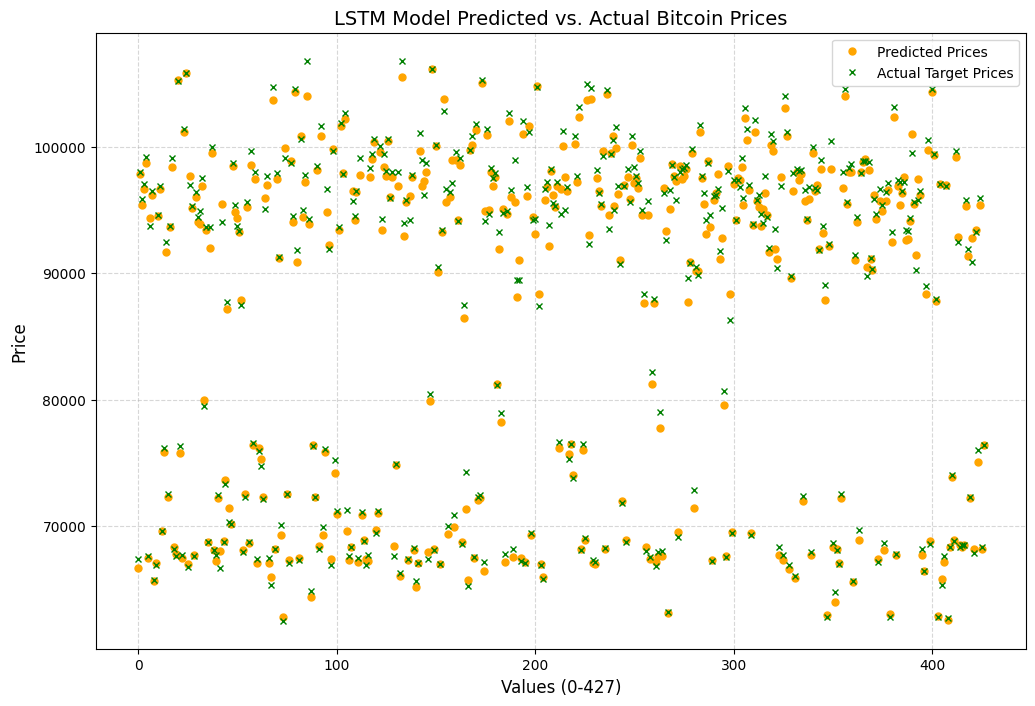

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Generate x values for 427 points
x_values = np.arange(427)

# Plot the data
plt.figure(figsize=(12, 8))
plt.plot(x_values, LSTM_y_pred_original, label="Predicted Prices", color="orange", marker='o', linestyle='None', markersize=5)
plt.plot(x_values, LSTM_y_test_original, label="Actual Target Prices", color="green", marker='x', linestyle='None', markersize=5)

# Add labels, title, legend, and grid
plt.title("LSTM Model Predicted vs. Actual Bitcoin Prices", fontsize=14)
plt.xlabel("Values (0-427)", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()


Evaulating LSTM Model

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_actual = LSTM_y_test_original.reshape(-1, 1)  # Actual target values
y_pred_LSTM = LSTM_y_pred_original  # Predictions from the model

# Ensure shapes match
assert y_actual.shape == y_pred_LSTM.shape, "Shapes of actual and predicted values do not match!"

# Evaluate the model
mse = mean_squared_error(y_actual, y_pred_LSTM)
mae = mean_absolute_error(y_actual, y_pred_LSTM)
r2 = r2_score(y_actual, y_pred_LSTM)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R^2): {r2:.4f}")


Mean Squared Error (MSE): 538520.1260
Mean Absolute Error (MAE): 532.8587
R-squared (R^2): 0.9971


In [15]:
# General Guidelines for Model Evaluation:
#     An Ideal Model would have:
#         - MSE close to 0.
#         - MAE close to 0.
#         - R² close to 1.


# From Our model the MAE and more significanly the R² method show us a good performance of the Model using the LSTM

Building ANN Model

In [16]:
#Artificial Nueral Network Model
    # Can be used for time series prediction Strengths: Capable of capturing complex patterns and non-linear relationships.
    # More control over number of layers, number of neurons, and activation functions

def ANN_Model(input_shape):
    ann = keras.models.Sequential()
    #input layer
    ann.add(keras.layers.Input(shape=input_shape))
    #hidden layers
    ann.add(keras.layers.Dense(50, activation='relu'))
    ann.add(keras.layers.Dense(128, activation='relu'))
    ann.add(keras.layers.Dense(64, activation='relu'))
    #output layer
    ann.add(keras.layers.Dense(1))

    ann.summary()
    ann.compile(optimizer='adam', loss='mse')

    return ann

In [17]:
ANN = ANN_Model((30, 1))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 30, 50)         │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30, 128)        │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30, 1)          │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,949 (58.39 KB)

 Trainable params: 14,949 (58.39 KB)

 Non-trainable params: 0 (0.00 B)

Training the ANN Model

In [18]:
ANN_history = ANN.fit(bit_seq_train, bit_targ_train, epochs=50, batch_size=32)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1709
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013   
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 13/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 14/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 15/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 16/50
54/5

Test and Evaluate ANN Model

In [19]:

# Predict and inverse-transform to original scale
ANN_y_pred = ANN.predict(bit_seq_test)
ANN_y_pred = ANN_y_pred.reshape(ANN_y_pred.shape[0], -1)
ANN_y_pred_original = scalar.inverse_transform(ANN_y_pred)
ANN_y_test_original = scalar.inverse_transform(bit_targ_test.reshape(-1, 1))


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [20]:
# The output of our model actually gave us a prediction for each price instead of getting a single prediction based on the 30 prices
# We will take the mean of the 30 predictions to give us one solid prediction so that we can reshape and restructure the array for our plot to visualize


# Use the last value in each segment
ANN_y_pred_column = ANN_y_pred_original[:, -1].reshape(-1, 1)

# Alternatively, Calculate the mean prediction for each row
#ANN_y_pred_column = np.mean(ANN_y_pred_original, axis=1).reshape(-1, 1)

# Check the shape and print
print(f"Original shape: {ANN_y_pred.shape}")
print(f"Reshaped shape: {ANN_y_pred_column.shape}")


Original shape: (427, 30)
Reshaped shape: (427, 1)


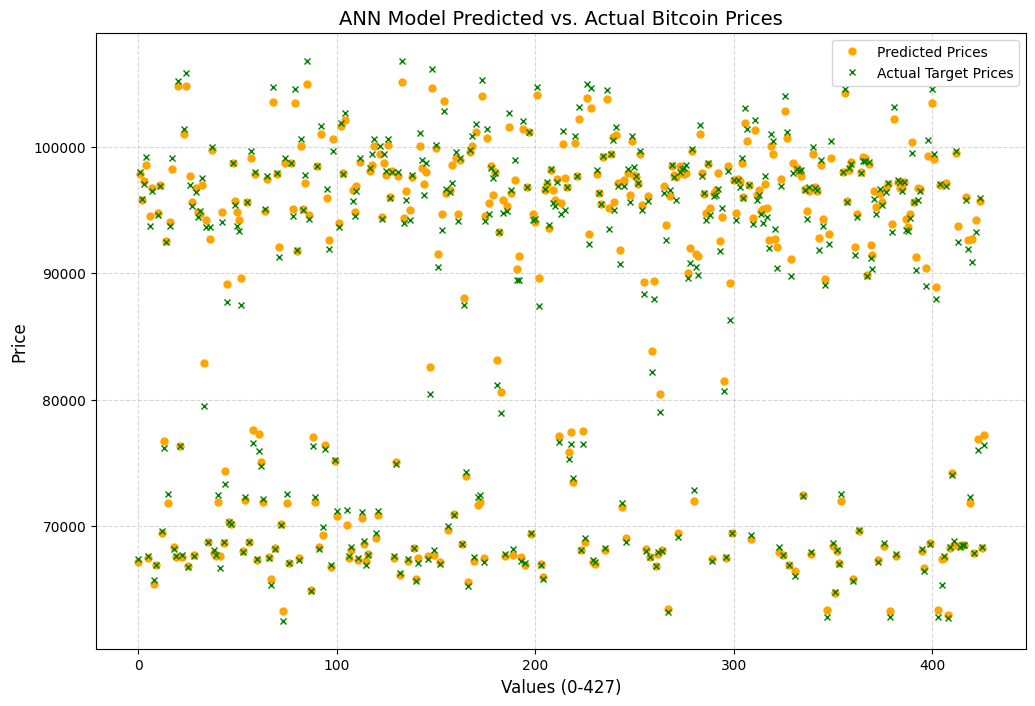

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Generate x values for 427 points
x_values = np.arange(427)

# Plot the data
plt.figure(figsize=(12, 8))
plt.plot(x_values, ANN_y_pred_column, label="Predicted Prices", color="orange", marker='o', linestyle='None', markersize=5)
plt.plot(x_values, ANN_y_test_original, label="Actual Target Prices", color="green", marker='x', linestyle='None', markersize=5)

# Add labels, title, legend, and grid
plt.title("ANN Model Predicted vs. Actual Bitcoin Prices", fontsize=14)
plt.xlabel("Values (0-427)", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()


Evaluating ANN Model

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_actual = ANN_y_test_original.reshape(-1, 1)  # Actual target values
y_pred_ann = ANN_y_pred_column  # Predictions from the model

# Ensure shapes match
assert y_actual.shape == y_pred_ann.shape, "Shapes of actual and predicted values do not match!"

# Evaluate the model
mse = mean_squared_error(y_actual, y_pred_ann)
mae = mean_absolute_error(y_actual, y_pred_ann)
r2 = r2_score(y_actual, y_pred_ann)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R^2): {r2:.4f}")


Mean Squared Error (MSE): 500848.5892
Mean Absolute Error (MAE): 506.4982
R-squared (R^2): 0.9973


In [ ]:
# General Guidelines for Model Evaluation:
#     An Ideal Model would have:
#         - MSE close to 0.
#         - MAE close to 0.
#         - R² close to 1.


# From Our model the MAE and more significanly the R² method show us a good performance of the Model using the ANN
# We actually beat the LSTM model by a tiny margin

Predicting Prices

In [111]:
def predict_prices(model, sequences, scaler):
    
    # This reshaping is typically done to prepare the data for input into a machine learning model, such as an LSTM, which expects data in a 3-dimensional format: [batch_size, sequence_length, num_features]
    last_sequence = sequences[-1].reshape(1, -1, 1)

    #Use model to predict the last sequence
    predicted_price_scaled = model.predict(last_sequence)

    # Inverse transform to get the actual price since the data is between 0-1 
    predicted_price = scaler.inverse_transform(predicted_price_scaled)

    return float(predicted_price[0][0])  # Convert to standard float

Data Preprocessing Without Test Train Split

In [ ]:
from sklearn.model_selection import train_test_split

def data_preprocessing_without_split(prices, sequence_length=30):
    scaler = MinMaxScaler()
    prices = np.array(prices).reshape(-1, 1)
    scaled_prices = scaler.fit_transform(prices)

    sequences = []
    targets = []
    for i in range(len(scaled_prices) - sequence_length):
        sequences.append(scaled_prices[i:i + sequence_length])
        targets.append(scaled_prices[i + sequence_length])

    return np.array(sequences), np.array(targets), scaler

In [ ]:
def rebalance_portfolio(current_allocation, predicted_prices, target_allocation):

    # This calculates the total current value of the portfolio by summing up the values in current_allocation
    current_value = sum(current_allocation)

   # This computes the target values of each asset in the portfolio based on the current total value and the target allocation percentages
    target_values = [current_value * ta for ta in target_allocation]

   # Calculate adjustments required to reach target values
    adjustments = []
    for current, target, predicted in zip(current_allocation, target_values, predicted_prices):
        # Adjust the current allocation based on predicted prices to meet the target allocation
        adjusted_value = target / predicted
        adjustments.append(adjusted_value - current)

    # Round adjustments and predicted prices to 3 decimal places for consistency
    adjustments = [round(adj, 3) for adj in adjustments]
    predicted_prices = [round(price, 3) for price in predicted_prices]

    return adjustments, predicted_prices